Checking the linear regression on 3 features, which seem most influential taken separately: 'Age', 'HP', 'Weight'. 

The final performance seems quite modest.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
# model

from sklearn.metrics import mean_squared_error
# metrics of quality of the fit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
# import the data
file_path  = 'ToyotaCorolla.csv'
data = pd.read_csv(file_path)
print(data.shape)  # (1436, 10)

# Select the target
target = [data.columns[0]]
print(target)  # ['Price']


# Select the features.
num_features = ['Age', 'HP', 'Weight']

df_X = data[num_features]
df_y = data[target]

print(type(df_X))  # 'pandas.core.frame.DataFrame'
print(df_X.shape)  # (1436,3)
print(type(df_y))  # 'pandas.core.series.Series'
print(df_y.shape)  # (1436,)

del file_path

(1436, 10)
['Price']
<class 'pandas.core.frame.DataFrame'>
(1436, 3)
<class 'pandas.core.frame.DataFrame'>
(1436, 1)


Naive attempt of Train-test split fails because of continuous data.
The prices should be subdivided into bins!

See: https://stackoverflow.com/a/70210854/3503724 ,
 https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html

for discretization.

N.B. Possible improvement.
This stratified subdivision in case of continuous variable can be transformed into a function,
or it would be event better if this function can be found.

Prototype.
data, params of KBinsDiscretizer , params of train_test_split
-> data_train, data_test

In [3]:
# discretizing the prices.
# Adapted from the stackoverflow link above.

price_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal')
#  default strategy : 'quantile'

y_discretized = price_discretizer.fit_transform(df_y)

print(type(price_discretizer))  # 'sklearn.preprocessing._discretization.KBinsDiscretizer'
print(price_discretizer.bin_edges_)
# array([ 4350.,  7450.,  7950.,  8750.,  8950.,  9900., 10500., 11250.,
#        12500., 15950., 32500.])

print(type(y_discretized))  # numpy.ndarray
print(y_discretized.shape)  # (1436,1) , Ok

# append y_discretized to the Dataframe.
data['discr_price'] = y_discretized

print(type(data))  # pandas.core.frame.DataFrame'
print(data.shape)  # 
data.head()  # (1436, 11)



<class 'sklearn.preprocessing._discretization.KBinsDiscretizer'>
[array([ 4350.,  7450.,  7950.,  8750.,  8950.,  9900., 10500., 11250.,
        12500., 15950., 32500.])                                       ]
<class 'numpy.ndarray'>
(1436, 1)
<class 'pandas.core.frame.DataFrame'>
(1436, 11)


,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight,discr_price
0,13500,23,46986,Diesel,90,1,0,2000,3,1165,8.0
1,13750,23,72937,Diesel,90,1,0,2000,3,1165,8.0
2,13950,24,41711,Diesel,90,1,0,2000,3,1165,8.0
3,14950,26,48000,Diesel,90,0,0,2000,3,1165,8.0
4,13750,30,38500,Diesel,90,0,0,2000,3,1170,8.0


<Axes: >

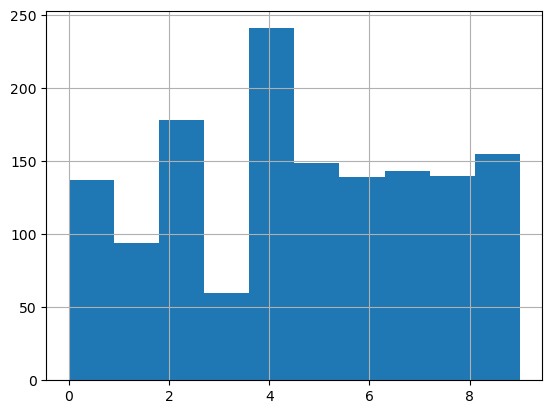

In [4]:
data['discr_price'].hist() 
# Surprizingly (for the quantile strategy), the histogram is not uniform:
# The bin with smallest size is 3, and the one with biggest size is 4 !
# Good news: each bin contains more than 50 samples.

In [5]:
# split according to the new column

data_train, data_test = train_test_split(data[num_features + target], test_size=0.2, stratify=data['discr_price'], random_state=42)
print(data_train.shape)  # (1148,4)
print(data_test.shape)   #  (288,4)

data_train.head()

# end of the function.

(1148, 4)
(288, 4)


,Age,HP,Weight,Price
1070,76,72,1140,7450
141,19,192,1185,23950
510,52,97,1060,11700
1060,71,110,1050,7950
451,47,110,1075,11750


Regression, cross-validation. Adapted from the previous script, to-check, modify output!

In [6]:
# Regression on the subset of features

# reg = LinearRegression().fit(df_X, df_y)
reg = LinearRegression().fit(data_train[num_features], data_train[target])

print(type(reg))  # 'sklearn.linear_model._base.LinearRegression'

# results of regression on training set
print(reg.score(data_train[num_features], data_train[target]))  # 0.843
print(reg.coef_)
# [[-147.5585553    41.76373875   14.23517379]]
print(reg.intercept_)
# [-501]

<class 'sklearn.linear_model._base.LinearRegression'>
0.8431310149409263
[[-147.5585553    41.76373875   14.23517379]]
[-500.85583307]


In [7]:
# testing set

price_pred_test = reg.predict(data_test[num_features])
# print(type(price_pred_test))  # ndarray
# print(price_pred_test.shape)  # (1436,)

# root-mean-square error

rmse0 = mean_squared_error(data_test[target], price_pred_test, squared= False)
print("RMSE of the linear regression:", rmse0)  # 1592 $ 
# In comparison, the std of prices equals:
print("Standard deviation of prices:", data[target].std())  # 3627 ->
# Standard deviation of prices: Price    3626.964585
# dtype: float64

del reg, price_pred_test

RMSE of the linear regression: 1592.380775495379
Standard deviation of prices: Price    3626.964585
dtype: float64


This rmse of 1600 $ per car should be compared to the result of AutoML (H2O , TPOT).